## Titanic 
In this competition we have data about Titanic's passengers. The data is divided into two files: train and test. In "train" file a column "Survival" shows whether the passenger survived or not.

At first I explore the data, modify it and create some new features, then I select the most important of them and make a prediction using Random Forest.

1. [Data exploration](#datex)

    1.1 [Pclass](#pclass)
    
    1.2 [Name](#name)
    
    1.3 [Age](#age)
    
    1.4 [Sex](#sex)
    
    1.5 [SibSp and Parch](#family)
    
    1.6 [Ticket](#ticket)
    
    1.7 [Fare](#fare)
    
    1.8 [Cabin](#cabin)
    
    1.9 [Embarked](#em)
    
2. [Data preparation](#datprer)

3. [Model](#model)

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel

## <a name="datex">Data exploration</a>

In [2]:
#Age is read as float, because later I'll need more precision for calculations.
train = pd.read_csv('../input/train.csv', dtype={'Age': np.float64}, )
test = pd.read_csv('../input/test.csv', dtype={'Age': np.float64}, )

In [3]:
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Boulos, Miss. Nourelain",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [4]:
df_test.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Mallet, Mrs. Albert (Antoinette Magnin)",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


819 rows in train data and 418 in test.
There are missing values in Age, Cabin and and Embarked columns in train and in Age and Cabin in test.
Name, Sex, Ticket, Cabin and Embarked are categorical variables.
Name contains a name itself and a title. Cabin and ticket consist of a letters and numbers.
Let's deal with each column step by step.

## <a name="pclass">Pclass</a>

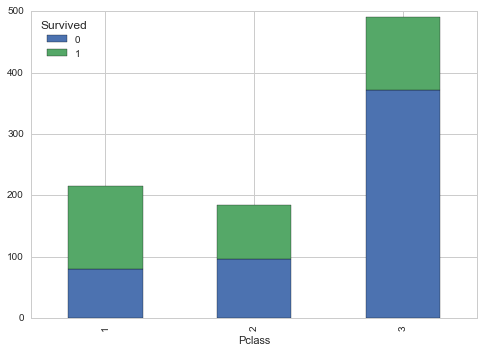

In [6]:
df_train.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(kind='bar', stacked=True)

Pclass. It seems that Pclass is useful and requires no changes. Passengers with Pclass 3 have less chances for survival. This is reasonable, as passengers with more expensive tickets lived at higher decks and thus could get to lifeboats faster.

## <a name="name">Name</a>

Names by themselves are useful. One way to use them is grouping people by family names - maybe families have better chance for survival? But it is complicated, and there is a better way to create a feature for families. Another way is extracting a title from the name and using it. Let's try.

In [7]:
df_train['Title'] = df_train['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))
df_test['Title'] = df_test['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))

df_train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Mme           1
Ms            1
Don           1
Countess      1
Sir           1
Lady          1
Jonkheer      1
Capt          1
Name: Title, dtype: int64

There are many titles, in fact it is a bad idea to use them as they are - I tried and the accuracy got worse. A good idea is grouping them by social status or something like that. I have found several ways to group them. Here is the one I chose.

In [8]:
titles = {'Capt':       'Officer',
          'Col':        'Officer',
          'Major':      'Officer',
          'Jonkheer':   'Royalty',
          'Don':        'Royalty',
          'Sir' :       'Royalty',
          'Dr':         'Officer',
          'Rev':        'Officer',
          'Countess':   'Royalty',
          'Dona':       'Royalty',
          'Mme':        'Mrs',
          'Mlle':       'Miss',
          'Ms':         'Mrs',
          'Mr' :        'Mr',
          'Mrs' :       'Mrs',
          'Miss' :      'Miss',
          'Master' :    'Master',
          'Lady' :      'Royalty'
                    } 

for k,v in titles.items():
    df_train.loc[df_train['Title'] == k, 'Title'] = v
    df_test.loc[df_test['Title'] == k, 'Title'] = v

#New frequencies.
df_train['Title'].value_counts()

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: Title, dtype: int64

## <a name="age">Age</a>

Missing values for Age should be filled. I think that simple mean/median isn't good enough. So I tried several ways to group other columns and chose median by Sex, Pclass and Title.

In [9]:
print(df_train.groupby(['Sex', 'Pclass', 'Title', ])['Age'].median())

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        40.0
                Officer    49.0
                Royalty    40.5
        2       Miss       24.0
                Mrs        31.5
        3       Miss       18.0
                Mrs        31.0
male    1       Master      4.0
                Mr         40.0
                Officer    51.0
                Royalty    40.0
        2       Master      1.0
                Mr         31.0
                Officer    46.5
        3       Master      4.0
                Mr         26.0
Name: Age, dtype: float64


In [10]:
df_train['Age'] = df_train.groupby(['Sex','Pclass','Title'])['Age'].apply(lambda x: x.fillna(x.median()))
df_test['Age'] = df_test.groupby(['Sex','Pclass','Title'])['Age'].apply(lambda x: x.fillna(x.median()))

## <a name="sex">Sex</a>

At first I wanted to divide passengers into males, females and children, but it increased overfitting. Also I tried to replace values with 1 and 0 (instead of creating dummies), it also worked worse. So doing nothing here.

In [11]:
df_train.groupby(['Pclass', 'Sex'])['Survived'].value_counts(normalize=True)

Pclass  Sex     Survived
1       female  1           0.968085
                0           0.031915
        male    0           0.631148
                1           0.368852
2       female  1           0.921053
                0           0.078947
        male    0           0.842593
                1           0.157407
3       female  0           0.500000
                1           0.500000
        male    0           0.864553
                1           0.135447
Name: Survived, dtype: float64

## <a name="family">SibSp and Parch</a>

Number of Siblings/Spouses and Parents/Children Aboard. Basically - amount of family members. So if we sum them, we get the size of the family. At first I created a single feature showing whether the person had family. It wasn't good enough. Then I tried several variants and stopped on four groups: 0 relatives, 1-2, 3 and 5 or more. From the table below we can see that such grouping makes sense.

In [12]:
df_train['Family'] = df_train['Parch'] + df_train['SibSp']
df_test['Family'] = df_test['Parch'] + df_test['SibSp']

In [13]:
df_train.groupby(['Family'])['Survived'].value_counts(normalize=True)

Family  Survived
0       0           0.696462
        1           0.303538
1       1           0.552795
        0           0.447205
2       1           0.578431
        0           0.421569
3       1           0.724138
        0           0.275862
4       0           0.800000
        1           0.200000
5       0           0.863636
        1           0.136364
6       0           0.666667
        1           0.333333
7       0           1.000000
10      0           1.000000
Name: Survived, dtype: float64

In [14]:
def FamilySize(x):
    """
    A function for Family size transformation
    """
    if x == 1 or x == 2:
        return 'little'
    elif x == 3:
        return 'medium'
    elif x >= 5:
        return 'big'
    else:
        return 'single'

df_train['Family'] = df_train['Family'].apply(lambda x : FamilySize(x))
df_test['Family'] = df_test['Family'].apply(lambda x : FamilySize(x))

In [15]:
df_train.groupby(['Pclass', 'Family'])['Survived'].mean()

Pclass  Family
1       big       0.500000
        little    0.734043
        medium    0.714286
        single    0.540541
2       big       1.000000
        little    0.600000
        medium    0.769231
        single    0.352381
3       big       0.095238
        little    0.384615
        medium    0.666667
        single    0.205357
Name: Survived, dtype: float64

## <a name="ticket">Ticket</a>

This value can't be used by itself. Ticket contains prefix and number. Using ticket number doesn't make sense, but prefix could be useful.

In [16]:
def Ticket_Prefix(x):
    """
    Function for extracting prefixes. Tickets have length of 1-3.
    """
    l = x.split()
    if len(x.split()) == 3:
        return x.split()[0] + x.split()[1]
    elif len(x.split()) == 2:
        return x.split()[0]
    else:
        return 'None'

df_train['TicketPrefix'] = df_train['Ticket'].apply(lambda x: Ticket_Prefix(x))
df_test['TicketPrefix'] = df_test['Ticket'].apply(lambda x: Ticket_Prefix(x))

In [17]:
#There are many similar prefixes, but combining them doesn't yield a significantly better result.
df_train.TicketPrefix.unique()

array(['A/5', 'PC', 'STON/O2.', 'None', 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'A4.', 'C', 'SOTON/O.Q.', 'SC/PARIS',
       'S.O.P.', 'A.5.', 'Fa', 'CA.', 'F.C.C.', 'W/C', 'SW/PP', 'SCO/W',
       'P/PP', 'SC', 'SC/AH', 'A/S', 'SC/AHBasle', 'A/4', 'WE/P',
       'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2', 'S.C./PARIS',
       'C.A./SOTON'], dtype=object)

## <a name="fare">Fare</a>

There is only one missing value, and in test. Fill it with median for its Pclass.

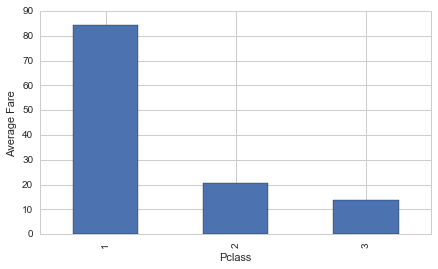

In [18]:
ax = plt.subplot()
ax.set_ylabel('Average Fare')
df_train.groupby('Pclass').mean()['Fare'].plot(kind='bar',figsize=(7, 4), ax=ax)
df_test['Fare'] = df_test.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.median()))

## <a name="cabin">Cabin</a>

I thought about ignoring this feature, but it turned out to be quite significant. And the most important for predicting was whether there was information about the Cabin or not.
So I fill NA with 'Unknown" value and use the first letter of the Cabin number as a feature.

In [19]:
df_train.Cabin.fillna('Unknown',inplace=True)
df_test.Cabin.fillna('Unknown',inplace=True)

df_train['Cabin'] = df_train['Cabin'].map(lambda x: x[0])
df_test['Cabin'] = df_test['Cabin'].map(lambda x: x[0])

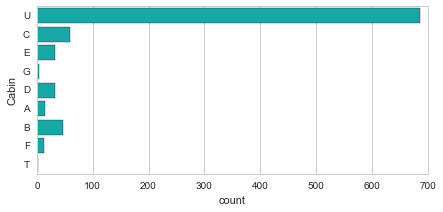

In [20]:
#Now let's see. Most of the cabins aren't filled.
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='Cabin', data=df_train, color='c')

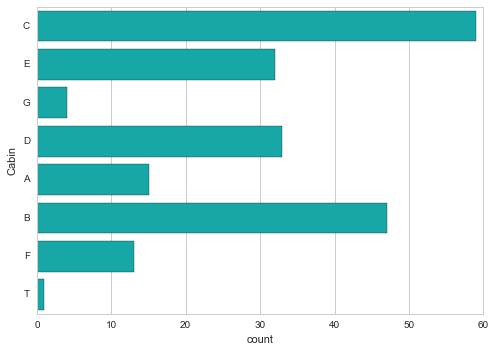

In [21]:
#Other cabins vary in number.
sns.countplot(y='Cabin', data=df_train[df_train.Cabin != 'U'], color='c')

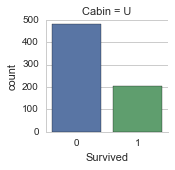

In [22]:
#Factorplot shows that most people, for whom there is no info on Cabin, didn't survive.
sns.factorplot('Survived', col='Cabin', col_wrap=4, data=df_train[df_train.Cabin == 'U'], kind='count', size=2.5, aspect=.8)

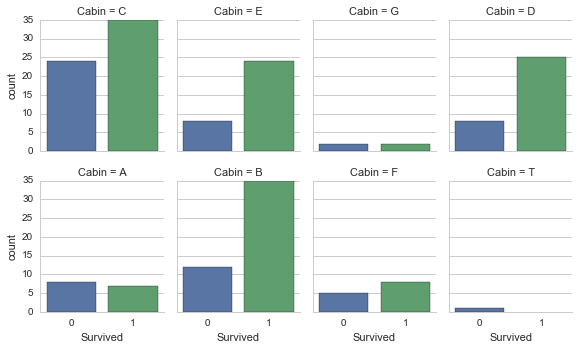

In [23]:
#For passengers with known Cabins survival rate varies.
sns.factorplot('Survived', col='Cabin', col_wrap=4, data=df_train[df_train.Cabin != 'U'], kind='count', size=2.5, aspect=.8)

In [24]:
df_train.groupby(['Cabin']).mean()[df_train.groupby(['Cabin']).mean().columns[1:2]]

,Survived
Cabin,
A,0.466667
B,0.744681
C,0.593220
D,0.757576
E,0.750000
F,0.615385
G,0.500000
T,0.000000
U,0.299854


## <a name="em">Embarked</a>

I simply fill na with most common value.

In [25]:
MedEmbarked = df_train.groupby('Embarked').count()['PassengerId']
df_train.Embarked.fillna(MedEmbarked, inplace=True)

## <a name="datprer">Data preparation</a>

In [26]:
#This is how the data looks like now.
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,Mr,little,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs,little,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Miss,single,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs,little,None
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,Mr,single,None


For most algorithms it is better to have only numerical data, therefore categorical variables should be changed. In some cases normalizing numerical data is necessary, but in this case this caused worse results.
I noticed that some columns with categorical values have different unique values in train and test.  I could deal with it by combining values in subgroups. But I decided to do feature selection first (lower) and the features selected were both in train and test.

In [27]:
#Drop unnecessary columns
to_drop = ['Ticket', 'Name', 'SibSp', 'Parch']
for i in to_drop:
    df_train.drop([i], axis=1, inplace=True)
    df_test.drop([i], axis=1, inplace=True)

In [28]:
#Pclass in fact is a categorical variable, though it's type isn't object.
for col in df_train.columns:
    if df_train[col].dtype == 'object' or col == 'Pclass':
        dummies = pd.get_dummies(df_train[col], drop_first=False)
        dummies = dummies.add_prefix('{}_'.format(col))
        df_train.drop(col, axis=1, inplace=True)
        df_train = df_train.join(dummies)
for col in df_test.columns:
    if df_test[col].dtype == 'object' or col == 'Pclass':
        dummies = pd.get_dummies(df_test[col], drop_first=False)
        dummies = dummies.add_prefix('{}_'.format(col))
        df_test.drop(col, axis=1, inplace=True)
        df_test = df_test.join(dummies)

In [29]:
#This is how the data looks like now.
df_train.head()

,PassengerId,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Family_big,Family_little,Family_medium,Family_single,TicketPrefix_A./5.,TicketPrefix_A.5.,TicketPrefix_A/4,TicketPrefix_A/4.,TicketPrefix_A/5,TicketPrefix_A/5.,TicketPrefix_A/S,TicketPrefix_A4.,TicketPrefix_C,TicketPrefix_C.A.,TicketPrefix_C.A./SOTON,TicketPrefix_CA,TicketPrefix_CA.,TicketPrefix_F.C.,TicketPrefix_F.C.C.,TicketPrefix_Fa,TicketPrefix_None,TicketPrefix_P/PP,TicketPrefix_PC,TicketPrefix_PP,TicketPrefix_S.C./A.4.,TicketPrefix_S.C./PARIS,TicketPrefix_S.O./P.P.,TicketPrefix_S.O.C.,TicketPrefix_S.O.P.,TicketPrefix_S.P.,TicketPrefix_S.W./PP,TicketPrefix_SC,TicketPrefix_SC/AH,TicketPrefix_SC/AHBasle,TicketPrefix_SC/PARIS,TicketPrefix_SC/Paris,TicketPrefix_SCO/W,TicketPrefix_SO/C,TicketPrefix_SOTON/O.Q.,TicketPrefix_SOTON/O2,TicketPrefix_SOTON/OQ,TicketPrefix_STON/O2.,TicketPrefix_SW/PP,TicketPrefix_W./C.,TicketPrefix_W.E.P.,TicketPrefix_W/C,TicketPrefix_WE/P
0,1,0,22.0,7.2500,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,38.0,71.2833,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,26.0,7.9250,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,4,1,35.0,53.1000,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,35.0,8.0500,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:

X_train = df_train.drop('Survived',axis=1)
Y_train = df_train['Survived']
X_test  = df_test

Now feature selection. This code ranks features by their importance for Random Forest. At first for parameters I used "n_estimators = 200" then I used more optimal parameters, which were found lower.

In [31]:
clf = RandomForestClassifier(n_estimators = 15,
                                criterion = 'gini',
                                max_features = 'sqrt',
                                max_depth = None,                                
                                min_samples_split =7,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 18)
clf = clf.fit(X_train, Y_train)
indices = np.argsort(clf.feature_importances_)[::-1]

print('Feature ranking:')
for f in range(X_train.shape[1]):
    print('%d. feature %d %s (%f)' % (f + 1, indices[f], X_train.columns[indices[f]], clf.feature_importances_[indices[f]]))

Feature ranking:
1. feature 22 Title_Mr (0.172049)
2. feature 6 Sex_female (0.158405)
3. feature 7 Sex_male (0.125303)
4. feature 5 Pclass_3 (0.076298)
5. feature 21 Title_Miss (0.071074)
6. feature 23 Title_Mrs (0.061872)
7. feature 1 Age (0.049752)
8. feature 2 Fare (0.044895)
9. feature 16 Cabin_U (0.034382)
10. feature 0 PassengerId (0.028074)
11. feature 26 Family_big (0.023500)
12. feature 3 Pclass_1 (0.021350)
13. feature 19 Embarked_S (0.019117)
14. feature 4 Pclass_2 (0.017256)
15. feature 29 Family_single (0.017157)
16. feature 9 Cabin_B (0.010840)
17. feature 28 Family_medium (0.009579)
18. feature 12 Cabin_E (0.008865)
19. feature 48 TicketPrefix_PC (0.007778)
20. feature 27 Family_little (0.007275)
21. feature 20 Title_Master (0.006684)
22. feature 17 Embarked_C (0.004819)
23. feature 39 TicketPrefix_C.A. (0.003906)
24. feature 18 Embarked_Q (0.003594)
25. feature 67 TicketPrefix_STON/O2. (0.003204)
26. feature 69 TicketPrefix_W./C. (0.001691)
27. feature 46 TicketPrefix_N

Feature selection by sklearn based on importance weights.

In [32]:
model = SelectFromModel(clf, prefit=True)
train_new = model.transform(X_train)
train_new.shape

(891, 15)

In [33]:
best_features = X_train.columns[indices[0:train_new.shape[1]]]
X = X_train[best_features]
Xt = X_test[best_features]
best_features

Index(['Title_Mr', 'Sex_female', 'Sex_male', 'Pclass_3', 'Title_Miss',
       'Title_Mrs', 'Age', 'Fare', 'Cabin_U', 'PassengerId', 'Family_big',
       'Pclass_1', 'Embarked_S', 'Pclass_2', 'Family_single'],
      dtype='object')

Usually SelectFromModel gives 13-15 features. Sex is most important, which isn't surprising - as we know, most places in boats were given to women. Fare and Pclass prove that difference in wealth is important. Age, of course, is important. Size of family and titles are also significant, as expected. Absense of info about the Cabin is indeed significant. And for some reason PassengerId is also important. Maybe data leak?

## <a name="model">Model</a>

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_train, test_size=0.33, random_state=44)

I saw the next part of code there: https://www.kaggle.com/creepykoala/titanic/study-of-tree-and-forest-algorithms
This is a great way to see how parameters influence the score of Random Forest.

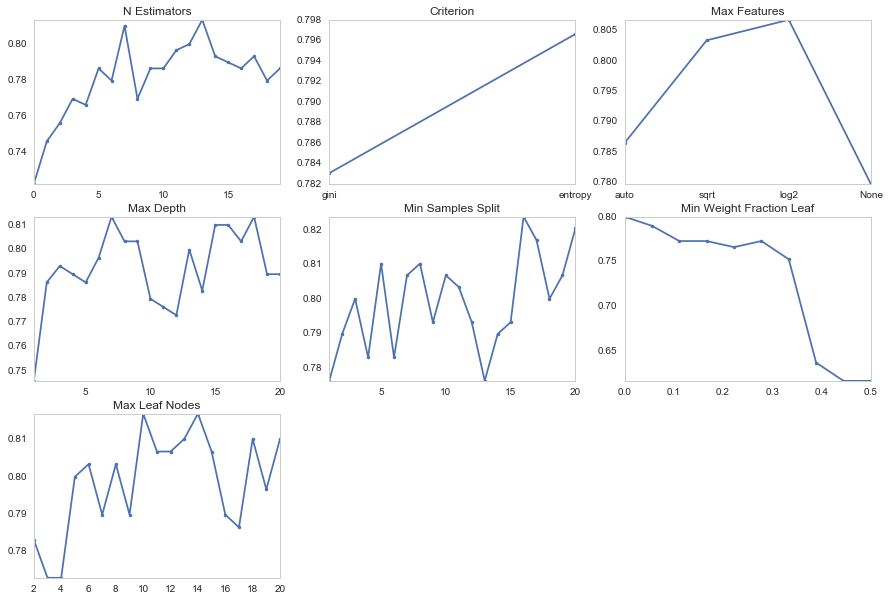

In [35]:
plt.figure(figsize=(15,10))

#N Estimators
plt.subplot(3,3,1)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(n_estimators=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(scores, '.-')
plt.axis('tight')
plt.title('N Estimators')
plt.grid();

#Criterion
plt.subplot(3,3,2)
feature_param = ['gini','entropy']
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(criterion=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(scores, '.-')
plt.title('Criterion')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Features
plt.subplot(3,3,3)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(scores, '.-')
plt.axis('tight')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Depth
plt.subplot(3,3,4)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(3,3,5)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Min Samples Split')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(3,3,6)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(3,3,7)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Max Leaf Nodes')
plt.grid();

Now based on these graphs I tune the model. Normally you input all parameters and their potential values and run GridSearchCV.
My PC isn't good enough so I divide parameters in two groups and repeatedly run two GridSearchCV until I'm satisfied with the result. This gives a balance between the quality and the speed.

In [36]:
forest = RandomForestClassifier(max_depth = 50,                                
                                min_samples_split =7,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 18)

parameter_grid = {'n_estimators' : [15, 100, 200],
                  'criterion' : ['gini', 'entropy'],
                  'max_features' : ['auto', 'sqrt', 'log2', None]
                 }

grid_search = GridSearchCV(forest, param_grid=parameter_grid, cv=StratifiedKFold(5))
grid_search.fit(X, Y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8226711560044894
Best parameters: {'max_features': None, 'criterion': 'entropy', 'n_estimators': 15}


In [37]:
forest = RandomForestClassifier(n_estimators = 200,
                                criterion = 'entropy',
                                max_features = None)
parameter_grid = {
                  'max_depth' : [None, 50],
                  'min_samples_split' : [7, 11],
                  'min_weight_fraction_leaf' : [0.0, 0.2],
                  'max_leaf_nodes' : [18, 20],
                 }

grid_search = GridSearchCV(forest, param_grid=parameter_grid, cv=StratifiedKFold(5))
grid_search.fit(X, Y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8013468013468014
Best parameters: {'max_leaf_nodes': 18, 'max_depth': None, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0}


In [38]:
#My optimal parameters
clf = RandomForestClassifier(n_estimators = 200,
                                criterion = 'entropy',
                                max_features = None,
                                max_depth = 50,                                
                                min_samples_split =7,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 18)

clf.fit(X, Y_train)
Y_pred_RF = clf.predict(Xt)

clf.score(X_test,y_test)

0.86101694915254234

In [39]:
submission = pd.DataFrame({
        'PassengerId': df_test['PassengerId'],
        'Survived': Y_pred_RF
    })
submission.to_csv('titanic.csv', index=False)

I didn't aim for a perfect model in this project, I just wanted to use my skills. The best result I got was 0.80861. Reachable maximum accuracy is ~82-85%, so I think that my result is good enough.